# **HKIA Historical Flight Information API Tutorial**

# Introduction

This tutorial guides you through using the API to access historical flight information from Hong Kong International Airport (HKIA)

* DATA.GOV.HK Website: https://data.gov.hk/en-data/dataset/aahk-team1-flight-info/resource/8f41b55c-a2ef-4963-bb25-96d8b21f3db4
* Data Specification: https://www.hongkongairport.com/iwov-resources/misc/opendata/Flight_Information_DataSpec_en.pdf

***Only data from TODAY-91 to TODAY+14 is available.***

In [200]:
# import necessary libraries:
import requests
import pandas as pd
import json

# **Fetching Flight Information**

## **The `get_json_flight_info` Function**
This function fetches HKIA flight information for a specific date and flight type through API:

### **Input**
* **date**: The target date for the flight information in 'YYYY-MM-DD' format.
* **arrival**: Set to True for arrival flights, False for departures.
* **cargo**: Set to True for cargo flights, False for passenger flights.
* **lang**: Language of the response ('en', 'zh_HK', or 'zh_CN'). Default is 'en'.

### **Returns**
* A JSON containing detailed flight information for the given parameters and date range.

In [201]:
def get_json_flight_info(date, arrival, cargo, lang='en'):

    arrival_str = 'true' if arrival else 'false'
    cargo_str = 'true' if cargo else 'false'

    url = f"https://www.hongkongairport.com/flightinfo-rest/rest/flights/past?date={date}&arrival={arrival_str}&cargo={cargo_str}&lang={lang}"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error: {response.status_code}")

### **Example of Usages**

In [202]:
# Valid
yesterday = (pd.to_datetime('today')-pd.Timedelta('1 days')).strftime('%Y-%m-%d')
flight_info = get_json_flight_info(date=yesterday, arrival=False, cargo=False, lang='en')
# print(json.dumps(flight_info, indent=2))

In [203]:
# Invalid
one_year_before = (pd.to_datetime('today')-pd.Timedelta('365 days')).strftime('%Y-%m-%d')
flight_info = get_json_flight_info(date=one_year_before, arrival=False, cargo=False, lang='en')

print(f"https://www.hongkongairport.com/flightinfo-rest/rest/flights/past?date={one_year_before}&arrival=false&cargo=false&lang=en")
# "message": "The combination of parameter date [2023-12-01] and span [1] is out of valid range (D-91 to D+14)."

Error: 400
https://www.hongkongairport.com/flightinfo-rest/rest/flights/past?date=2023-03-24&arrival=false&cargo=false&lang=en


# **Preprocessing**

## **The `preprocessing` Function**
This function preprocesses JSON flight information.

### **Input**
* `json_flight_info` returned from `get_json_flight_info` function
* **col**:  Optional; a list of column names as strings to specify which columns to include. Defaults to "None," indicating all columns are returned.

### **Returns**
* A pandas DataFrame containing detailed flight information based on `json_flight_info`

In [204]:
def preprocessing(json_flight_info, col=None):
    df = pd.json_normalize(json_flight_info, 'list')
    df.insert(loc=0, column='info_date', value=json_flight_info[0]['date'])
    if col is not None:
        df = df[col]
    if 'flight' in df.columns:
        df['flight'] = df['flight'].apply(lambda x: [f"{flight['no']} ({flight['airline']})" for flight in x])
    return df

## **The `get_df_flight_info` Function**
This function uses the above two function to get pandas dataframe format flight info within day ranges

### **Input**
* **start_date, end_date**: Specifies the query range ('YYYY-MM-DD').
> *(For a single-day query, set both start_date and end_date to the same value.)*



* **arrival, cargo, lang**: Same as those in `get_json_flight_info`

### **Returns**
* A pandas DataFrame containing detailed flight information for the given parameters and date range.

In [205]:
def get_df_flight_info(start_date, end_date, arrival, cargo, lang='en', col=None):

    date_list = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m-%d').tolist()

    df_list = []
    for date in date_list:
        json_flight_info = get_json_flight_info(date, arrival, cargo, lang)
        df = preprocessing(json_flight_info, col)
        df_list += [df]

    return pd.concat(df_list).reset_index()

### **Example of Usages**

In [206]:
# single-day query
yesterday = (pd.to_datetime('today')-pd.Timedelta('1 days')).strftime('%Y-%m-%d')
flight_info = get_df_flight_info(start_date=yesterday, end_date=yesterday, arrival=False, cargo=False)
flight_info.head()

,index,info_date,time,flight,status,statusCode,destination,terminal,aisle,gate
0,0,2024-03-21,23:35,[CX 255 (CPA)],Dep 00:04 (22/03/2024),None,[LHR],T1,BC,2
1,1,2024-03-21,23:45,[ET 645 (ETH)],Dep 00:07 (22/03/2024),None,[ADD],T1,D,31
2,2,2024-03-21,00:05,[CX 261 (CPA)],Dep 00:15,None,[CDG],T1,A,49
3,3,2024-03-21,00:15,"[CX 289 (CPA), LH 7015 (DLH)]",Dep 00:22,None,[FRA],T1,A,66
4,4,2024-03-21,00:15,"[CX 880 (CPA), MH 9190 (MAS), OM 5880 (MGL), A...",Dep 00:24,None,[LAX],T1,BC,9


# **Visualizing Flight Data**
With the data processed, we can now visualize it to uncover insights. For example, to visualize the count of flights by origin or destination:

## Top `N` `locations` by Flight Counts within 30 Days

<Axes: title={'center': 'Top 20 Flight Counts by Destination'}>

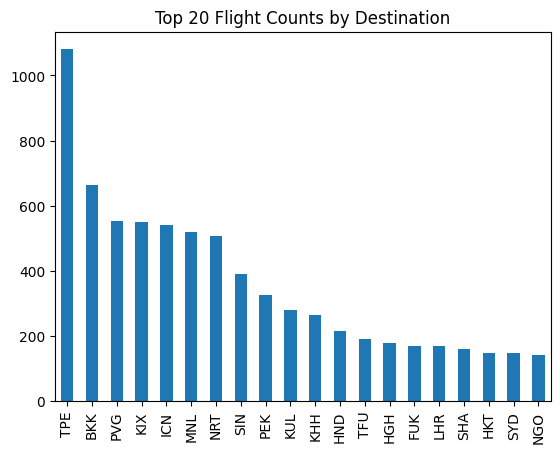

In [207]:
N = 20
today = pd.to_datetime('today').strftime('%Y-%m-%d')
thirty_days_before = (pd.to_datetime('today')-pd.Timedelta('30 days')).strftime('%Y-%m-%d')
df = get_df_flight_info(start_date=thirty_days_before, end_date=today, arrival=False, cargo=False, col=["destination"])

if 'origin' in df.columns:
    location = 'Origin'
    info = df['origin']

if 'destination' in df.columns:
    location = 'Destination'
    info = df['destination']

counts = info.explode().value_counts()[:N]
counts.plot.bar(title=f'Top {N} Flight Counts by {location}')